<a href="https://colab.research.google.com/github/TheLusca/tapajos_river_streamflow/blob/master/streamflow_tapajos_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Este notebook contém as etapas de processamento de dados da Rede Hidrometeorológica Nacional (RHN) pertencente a Agência Nacional de Águas (ANA) para a montagem do dataset da rede neural Long short-term memory (LSTM)

✏ author: Lucas de Andrade https://github.com/TheLusca

Source: https://www.snirh.gov.br/hidroweb/serieshistoricas

Código das estações:

*   17430000 - BARRA DO SÃO MANUEL
*   17710000 - BUBURÉ
*   17730000 - ITAITUBA
*   17900000 - SANTAREM

# Manter conexão com o Collab

Pare de sair do Google Colab
Aqui está a solução (fonte): antes de rodar o seu notebook, basta abrir o Chrome DevTools pressionando F12 (ou Ctrl + Shift + I no Linux) e executar o seguinte código JavaScript em seu console:

```
function KeepClicking(){
   console.log("Clicking");
   document.querySelector("colab-toolbar-button#connect").click()
}setInterval(KeepClicking,60000)
```

Aqui, o valor 60.000 representa os milissegundos (equivalente a um minuto). Esse pequeno código clica na tela do Colab a cada 60 segundos. Assim, o Colab pensa que o notebook não está silencioso e você não precisa se preocupar em ser desconectado

[Como Treinar um modelo no google collab](https://medium.com/@pierre_guillou/como-treinar-um-modelo-de-deep-learning-no-colab-e3cc4da64d9a)

# Conectar ao google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


# Criar diretório de trabalho

In [ ]:
import os

if not os.path.isdir('tapajos_data'):
  os.makedirs('tapajos_data')
  os.makedirs('tapajos_data/data')
  os.makedirs('tapajos_data/data/1_raw')
  os.makedirs('tapajos_data/data/2_filtered')
  os.makedirs('tapajos_data/data/3_staged')
  os.makedirs('tapajos_data/data/4_results')

# Acessar e visualizar o diretório

In [ ]:
%cd /content/gdrive/MyDrive/tapajos_data/data

%pwd
print('\nEstrutura de Arquivos:')
%ls

/content/gdrive/MyDrive/tapajos_data/data

Estrutura de Arquivos:
1_raw/  2_filtered/  3_staged/  4_results/


# Data process


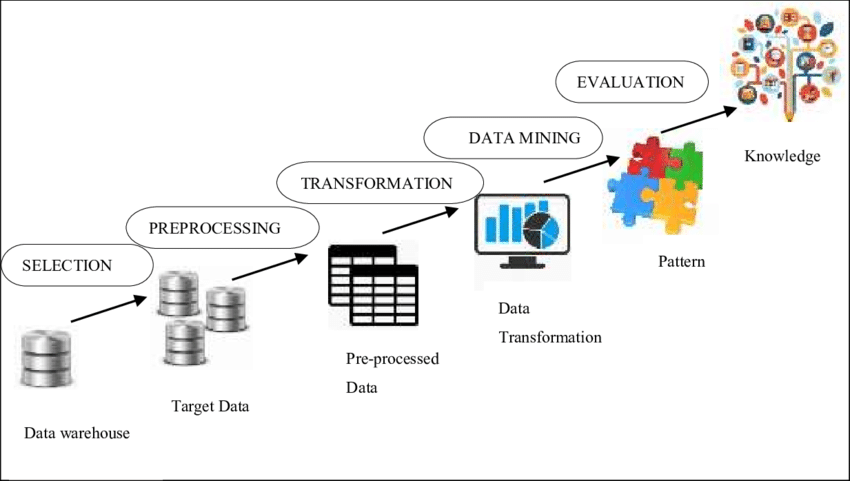

# Visal geral dos dados

O gráfico gerado pelo script é um boxplot que compara as cotas mínimas e máximas por ano. A análise visual pode revelar:

1. Variação Anual: Como as cotas mínimas e máximas variam ao longo dos anos.
2. Tendências de Longo Prazo: Se há tendências de aumento ou diminuição nas cotas mínimas e máximas ao longo do tempo.
3. Extremos e Outliers: A presença de valores extremos e outliers nas cotas mínimas e máximas.
4. Diferenças entre Tipos de Cota: Como as cotas mínimas e máximas se comparam em termos de dispersão e tendência.

Cotas Minimas por Ano:
Ano
1999    270.0
2000    284.0
2001    288.0
2002    281.0
2003    273.0
2004    309.0
2005    287.0
2006    309.0
2007    285.0
2008    298.0
2009     35.0
2010    277.0
2011    285.0
2012    300.0
2013    304.0
2014    315.0
2015    302.0
2016    266.0
2017    281.0
2018    298.0
2019    301.0
2020    280.0
2021    278.0
2022    278.0
2023    286.0
Name: Minima, dtype: float64

Cotas Maximas por Ano:
Ano
1999     789.0
2000     930.0
2001     868.0
2002     947.0
2003     973.0
2004    1177.0
2005     953.0
2006     956.0
2007     980.0
2008     982.0
2009     858.0
2010     921.0
2011     913.0
2012     919.0
2013     997.0
2014    1089.0
2015     908.0
2016     780.0
2017     898.0
2018     938.0
2019    1029.0
2020     973.0
2021     931.0
2022     994.0
2023     995.0
Name: Maxima, dtype: float64


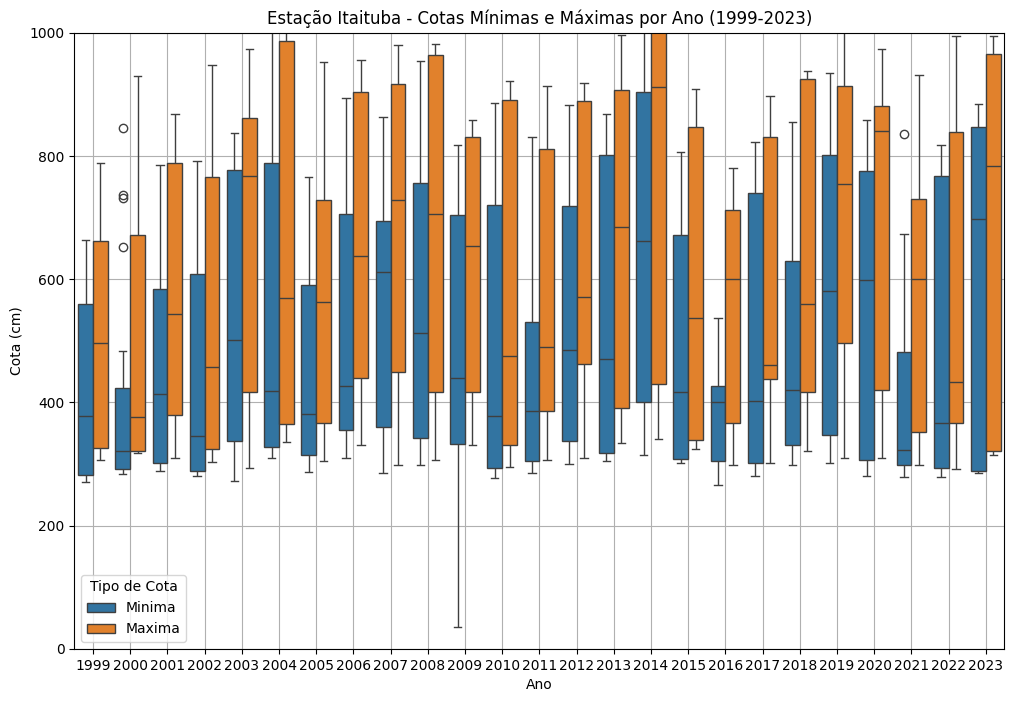

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#dados = pd.read_csv('1_raw/barra_sao_manuel_cotas.csv')
#dados = pd.read_csv('1_raw/bubure_Cotas.csv')
dados = pd.read_csv('1_raw/itaituba_cotas.csv')
#dados = pd.read_csv('1_raw/santarem_cotas.csv')

dados['Data'] = pd.to_datetime(dados['Data'])
dados['Ano'] = dados['Data'].dt.year
dados_filtrados = dados[(dados['Ano'] >= 1999) & (dados['Ano'] <= 2023)]

minimas_por_ano = dados_filtrados.groupby('Ano')['Minima'].min()
maximas_por_ano = dados_filtrados.groupby('Ano')['Maxima'].max()

print("Cotas Minimas por Ano:")
print(minimas_por_ano)
print("\nCotas Maximas por Ano:")
print(maximas_por_ano)

dados_long = dados_filtrados.melt(id_vars='Ano', value_vars=['Minima', 'Maxima'],
                                  var_name='Tipo', value_name='Cota')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Ano', y='Cota', hue='Tipo', data=dados_long)

plt.ylim(0, 1000)

plt.title('Estação Itaituba - Cotas Mínimas e Máximas por Ano (1999-2023)')
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.grid(True)
plt.legend(title='Tipo de Cota')
plt.show()


# Limpeza e Filtragem de dados

In [ ]:
import pandas as pd

"""
Faz uma filtragem de dados basenado nas informações do cabeçalho do csv bruto baixado da hidroweb:
    NivelConsistencia: 1 = Bruto	 2 = Consistido
    MediaDiaria: Indica se a medição é média diaria ou instantânea.  0 = Não 	 1 = Sim
    TipoMedicaoCotas: 1 = Escala	 2 = Linégrafo	 3 = Data Logger	 5 = Escala SMS
    Status: 0 = Branco	 1 = Real	 2 = Estimado	 3 = Duvidoso	 4 = Régua Seca

Optei por:
    meda diaria = 1 //para utilizar somente uma medição media por dia
    nivel de consistencia = 1 //por se tratar de um valor bruto
"""
#df = pd.read_csv('1_raw/barra_sao_manuel_cotas.csv')
#df = pd.read_csv('1_raw/bubure_cotas.csv')
df = pd.read_csv('1_raw/itaituba_cotas.csv')
#df = pd.read_csv('1_raw/santarem_cotas.csv')


#df_limpo = df.dropna(subset=['hora']) # eliminar as linhas sem hora
#df_limpo = df[df['MediaDiaria'] != 0] # manter somente a linha de media diaria
df_limpo = df[(df['MediaDiaria'] != 0) & (df['NivelConsistencia'] == 1)]

df_limpo.to_csv('2_filtered/arquivo_filtrado.csv', index=False)

print(f"Arquivo salvo com sucesso! Linhas removidas: {len(df) - len(df_limpo)}")


Arquivo salvo com sucesso! Linhas removidas: 1514


# Normalização de dados

#Escore - z

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/2_filtered/arquivo_filtrado.csv')
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

data_inicio = '2024-01-01'
data_fim = '2024-05-01'

df_filtrado = df[(df['Data'] >= data_inicio) & (df['Data'] <= data_fim)]

cotas = df_filtrado[['Cota01', 'Cota02', 'Cota03', 'Cota04', 'Cota05', 'Cota06', 'Cota07', 'Cota08',
                     'Cota09', 'Cota10', 'Cota11', 'Cota12', 'Cota13', 'Cota14', 'Cota15', 'Cota16',
                     'Cota17', 'Cota18', 'Cota19', 'Cota20', 'Cota21', 'Cota22', 'Cota23', 'Cota24',
                     'Cota25', 'Cota26', 'Cota27', 'Cota28', 'Cota29', 'Cota30', 'Cota31']]

# Normalização Z-score
scaler = StandardScaler()
cotas_normalizadas = scaler.fit_transform(cotas)

df_filtrado_normalizado = pd.DataFrame(cotas_normalizadas, columns=cotas.columns)
df_filtrado_normalizado['Data'] = df_filtrado['Data'].values
df_filtrado_normalizado = df_filtrado_normalizado[['Data'] + list(cotas.columns)]

df_filtrado_normalizado.to_csv('data/3_staged/itaituba_cotas_escorez_normalizado.csv', index=False)
print("Arquivo CSV com normalizacao escore-z salvo com sucesso!")


# MinMax

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Carregar o arquivo CSV
df = pd.read_csv('2_filtered/arquivo_filtrado.csv')

# Converter a coluna 'Data' para o formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

# Definir o intervalo de datas
data_inicio = '2024-01-01'
data_fim = '2024-05-01'

# Filtrar o DataFrame com base no intervalo de datas
df_filtrado = df[(df['Data'] >= data_inicio) & (df['Data'] <= data_fim)]

# Selecionar as colunas de Cota01 a Cota31
cotas = df_filtrado[['Cota01', 'Cota02', 'Cota03', 'Cota04', 'Cota05', 'Cota06', 'Cota07', 'Cota08',
                     'Cota09', 'Cota10', 'Cota11', 'Cota12', 'Cota13', 'Cota14', 'Cota15', 'Cota16',
                     'Cota17', 'Cota18', 'Cota19', 'Cota20', 'Cota21', 'Cota22', 'Cota23', 'Cota24',
                     'Cota25', 'Cota26', 'Cota27', 'Cota28', 'Cota29', 'Cota30', 'Cota31']]

# Aplicar a normalização Min-Max
scaler = MinMaxScaler()
cotas_normalizadas = scaler.fit_transform(cotas)

# Criar um novo DataFrame com os dados normalizados
df_filtrado_normalizado = pd.DataFrame(cotas_normalizadas, columns=cotas.columns)

# Adicionar a coluna 'Data' de volta ao DataFrame normalizado
df_filtrado_normalizado['Data'] = df_filtrado['Data'].values

# Reordenar as colunas para que 'Data' seja a primeira
df_filtrado_normalizado = df_filtrado_normalizado[['Data'] + list(cotas.columns)]

# Salvar o DataFrame normalizado em um novo CSV
df_filtrado_normalizado.to_csv('3_staged/itaituba_2024.csv', index=False)

print("Arquivo CSV com normalização Min-Max salvo com sucesso!")


Arquivo CSV com normalização Min-Max salvo com sucesso!


################################################################################

# Análise por cota diária

Analisar o comportamento dos niveis diários de um determinado mês

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def gerar_grafico_tendencia(arquivo_csv):
    df = pd.read_csv(arquivo_csv)

    data = '2023-11-01'
    linha_selecionada = df[df['Data'] == data]

    if linha_selecionada.empty:
        print(f"Data {data} nao encontrada no arquivo.")
        return

    # Remover a coluna de Data e transformar as cotas em uma série contínua para análise
    cotacoes = linha_selecionada.drop(columns=['Data']).T
    cotacoes.columns = ['Cota']

    plt.figure(figsize=(10, 6))
    plt.plot(cotacoes.index, cotacoes['Cota'], marker='o', linestyle='-', color='b', label='Cotas Diárias')
    plt.title(f'Tendência das Cotas Diárias MinMax {data}')
    plt.xlabel('Dias')
    plt.ylabel('Cota')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()

    plt.show()

#arquivo_csv = '3_staged/barra_sao_manuel_cotas_minmax_normalizado.csv'
arquivo_csv = '3_staged/santarem.csv'
gerar_grafico_tendencia(arquivo_csv)


# Tendência de aumento/diminuição mensal

Analisar a tendência de aumento ou diminuição mensal


Cálculo da média mensal: A função mean(axis=1) é usada para calcular a média das cotas diárias de cada mês para te  uma visão geral do comportamento de cada mês de um determinado ano

Comparar as médias mensais: Após obter as médias de cada mês, compare-as entre si para identificar a tendência de aumento ou diminuição. Se a média de um mês for maior que a do mês anterior, isso indica uma tendência de aumento.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('3_staged/2024/santarem_2024.csv')


df['Data'] = pd.to_datetime(df['Data'])
df['MediaMensal'] = df.iloc[:, 1:].mean(axis=1)

ano_escolhido = 2024
df_ano = df[df['Data'].dt.year == ano_escolhido]

if df_ano.empty:
    print(f"Nenhum dado encontrado para o ano {ano_escolhido}.")
else:

    df_ano = df_ano.sort_values(by='Data')
    print(df_ano[['Data', 'MediaMensal']])

    plt.plot(df_ano['Data'], df_ano['MediaMensal'], marker='o')

    # Configurar o eixo x para mostrar todos os pontos (datas)
    plt.xticks(df_ano['Data'], df_ano['Data'].dt.strftime('%m'), rotation=45)  # Formatar como dia/mês

    plt.title(f'Tendência de Aumento/Diminuição Mensal em {ano_escolhido}')
    plt.xlabel('Data')
    plt.ylabel('Média das Cotas')
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados

#df = pd.read_csv('3_staged/santarem_cotas_escorez_normalizado.csv')
df = pd.read_csv('3_staged/santarem_2024.csv')

# Converter a coluna 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'])

# Calcular a média das colunas (exceto 'Data')
df['MediaMensal'] = df.iloc[:, 1:].mean(axis=1)

# Adicionar uma coluna com o mês correspondente
df['Mes'] = df['Data'].dt.month

# Ordenar os dados pela data
df = df.sort_values(by='Data')

# Agrupar os dados por mês e criar uma lista de valores de 'MediaMensal' para cada mês
dados_por_mes = [df[df['Mes'] == mes]['MediaMensal'] for mes in range(1, 13)]

# Plotar o boxplot das médias mensais agrupadas por mês
plt.boxplot(dados_por_mes, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Configurações do gráfico
plt.title('Distribuição das Médias Mensais (Boxplot)')
plt.xlabel('Meses')
plt.ylabel('Média das Cotas')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dois arquivos CSV
arquivo1 = '3_staged/2024/santarem_2024.csv'
arquivo2 = '3_staged/2024/santarem_previsoes2024.csv'


# Ler os arquivos como DataFrames
df1 = pd.read_csv(arquivo1, parse_dates=['Data'], dayfirst=True)
df2 = pd.read_csv(arquivo2, parse_dates=['Data'], dayfirst=True)

# Definir a coluna de datas como o índice
df1.set_index('Data', inplace=True)
df2.set_index('Data', inplace=True)

# Calcular a média de cada linha para obter a média mensal
df1['Media_Mensal'] = df1.mean(axis=1)
df2['Media_Mensal'] = df2.mean(axis=1)

# Plotar o gráfico de linha para as médias mensais
plt.figure(figsize=(10, 6))

# Plotar as médias mensais dos dois arquivos
plt.plot(df1.index, df1['Media_Mensal'], label='Média Mensal Santarém - Real', color='blue', marker='o')
plt.plot(df2.index, df2['Media_Mensal'], label='Média Mensal Santarém - Predito', color='orange', marker='o')

# Configurações do gráfico
plt.title('Comparação de Médias Mensais entre Arquivos')
plt.xlabel('Data')
plt.ylabel('Média Mensal')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()


Média Mensal do Primeiro Arquivo:
        Data  MediaMensal
4 2024-01-01     0.000000
3 2024-02-01     0.417307
2 2024-03-01     0.616849
1 2024-04-01     0.947035
0 2024-05-01     0.813683
Média Mensal do Segundo Arquivo:
        Data  MediaMensal
4 2024-01-01     0.308504
3 2024-02-01     0.353298
2 2024-03-01     0.384309
1 2024-04-01     0.399550
0 2024-05-01     0.402146


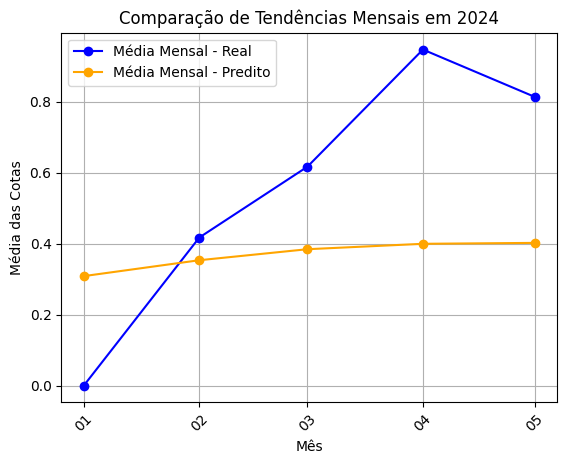

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o primeiro arquivo CSV
arquivo1 = '3_staged/2024/itaituba_2024.csv'
df1 = pd.read_csv(arquivo1)

# Carregar o segundo arquivo CSV
arquivo2 = '3_staged/2024/itaituba_2024_previsoes.csv'  # Caminho do segundo arquivo
df2 = pd.read_csv(arquivo2)

# Converter a coluna "Data" para o tipo datetime
df1['Data'] = pd.to_datetime(df1['Data'])
df2['Data'] = pd.to_datetime(df2['Data'])

# Calcular a média para cada linha e armazenar em uma nova coluna
df1['MediaMensal'] = df1.iloc[:, 1:].mean(axis=1)
df2['MediaMensal'] = df2.iloc[:, 1:].mean(axis=1)

# Escolher o ano para a análise
ano_escolhido = 2024

# Filtrar os dados pelo ano escolhido
df1_ano = df1[df1['Data'].dt.year == ano_escolhido]
df2_ano = df2[df2['Data'].dt.year == ano_escolhido]

# Verificar se ambos os arquivos têm dados para o ano escolhido
if df1_ano.empty:
    print(f"Nenhum dado encontrado para o ano {ano_escolhido} no primeiro arquivo.")
if df2_ano.empty:
    print(f"Nenhum dado encontrado para o ano {ano_escolhido} no segundo arquivo.")

# Plotar os dados apenas se ambos tiverem dados disponíveis para o ano escolhido
if not df1_ano.empty and not df2_ano.empty:
    # Ordenar os dados pela data
    df1_ano = df1_ano.sort_values(by='Data')
    df2_ano = df2_ano.sort_values(by='Data')

    # Exibir as médias mensais dos dois arquivos
    print("Média Mensal do Primeiro Arquivo:")
    print(df1_ano[['Data', 'MediaMensal']])
    print("Média Mensal do Segundo Arquivo:")
    print(df2_ano[['Data', 'MediaMensal']])

    # Plotar os gráficos de médias mensais
    plt.plot(df1_ano['Data'], df1_ano['MediaMensal'], marker='o', label='Média Mensal - Real', color='blue')
    plt.plot(df2_ano['Data'], df2_ano['MediaMensal'], marker='o', label='Média Mensal - Predito', color='orange')

    # Configurar o eixo x para mostrar apenas os meses
    plt.xticks(df1_ano['Data'], df1_ano['Data'].dt.strftime('%m'), rotation=45)

    # Configurações do gráfico
    plt.title(f'Comparação de Tendências Mensais em {ano_escolhido}')
    plt.xlabel('Mês')
    plt.ylabel('Média das Cotas')
    plt.legend()
    plt.grid(True)

    # Exibir o gráfico
    plt.show()
else:
    print("Não foi possível plotar os dados para o ano escolhido.")
